## Loading Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#for data preprocessing
from sklearn.preprocessing import MinMaxScaler

## Load training set

Need to load the data as numpy ndarray as Keras can only accept that

In [2]:
data_train = pd.read_csv("data/Google_Stock_Price_Train.csv")
data_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
len(data_train.Date.unique()), data_train.Date.unique()

(1258, array(['1/3/2012', '1/4/2012', '1/5/2012', ..., '12/28/2016',
        '12/29/2016', '12/30/2016'], dtype=object))

Take only the columns we want

In [4]:
training_set = data_train.iloc[:, 1:2].values
print("Training shape ", training_set.shape)
print("Training data ", training_set[:5])


Training shape  (1258, 1)
Training data  [[325.25]
 [331.27]
 [329.83]
 [328.34]
 [322.04]]


## Data Preprocessing

Since we are using softmax for the activation layer in the RNN, it is recommended to use Normalization

In [5]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

Creating a data structure with 60 timesteps (how many data from before do we look) and 1 output

In [6]:
X_train = []
y_train = []

for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((1198, 60), (1198,))

Add another feature (dimension)

In [7]:
#Batch size, timesteps, number of indicators/features
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1198, 60, 1)

## Part 2 - Build the RNN (LSTM)

### Importing Keras Libraries

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


### Init the RNN

In [9]:
regressor = Sequential()
# numebr of units (in the layer)
# return sequences? set it to True because we want to add another LSTM layer (stacked LSTM)
# input shape - the last two shape (time sequences and number of features)

#add the first LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate=0.2))
#add the second LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True)) #the input shape is recognized automatically from the prev LSTM
regressor.add(Dropout(rate=0.2))
#add the third LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(rate=0.2))
#add the fourth LSTM layer
regressor.add(LSTM(units = 50)) #since it is the last, the return_sequences is False or default
regressor.add(Dropout(rate=0.2))

#Add the output layer
regressor.add(Dense(units = 1))

#Compile the RNN
regressor.compile(optimizer = 'adam', loss='mean_squared_error')

### Fit the RNN

In [10]:
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0451
Epoch 2/100
1198/1198 [==============================] - 4s 4ms/step - loss: 0.0069
Epoch 3/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0054
Epoch 4/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0054
Epoch 5/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0053
Epoch 6/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0051
Epoch 7/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0045
Epoch 8/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0042
Epoch 9/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0046
Epoch 10/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0044
Epoch 11/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0041
Epoch 12/100
1198/1198 [==============================] - 5s 4ms/step - lo

1198/1198 [==============================] - 4s 3ms/step - loss: 0.0014
Epoch 98/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0014
Epoch 99/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0013
Epoch 100/100
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0013


## Load Testing data

### Get real stock price

In [21]:
data_test = pd.read_csv("data/Google_Stock_Price_Test.csv")
real_stock_price = data_test.iloc[:, 1:2].values
real_stock_price

array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ],
       [807.86],
       [805.  ],
       [807.14],
       [807.48],
       [807.08],
       [805.81],
       [805.12],
       [806.91],
       [807.25],
       [822.3 ],
       [829.62],
       [837.81],
       [834.71],
       [814.66],
       [796.86]])

### Get predicted stock price

In [22]:
dataset_total = pd.concat((data_train['Open'], data_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total)-len(data_test)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
inputs.shape

(80, 1)

In [23]:
X_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#Batch size, timesteps, number of indicators/features
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(20, 60, 1)

## Start predicting

In [25]:
predicted_stock_price = regressor.predict(X_test)
#Inverse min max transform to get actual value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price

array([[787.46844],
       [784.5583 ],
       [784.3279 ],
       [785.4146 ],
       [788.5977 ],
       [794.4112 ],
       [800.01135],
       [802.60486],
       [803.0714 ],
       [802.6135 ],
       [802.0263 ],
       [801.5327 ],
       [801.30084],
       [801.8898 ],
       [803.0096 ],
       [807.60486],
       [814.6055 ],
       [822.3045 ],
       [826.8091 ],
       [823.2433 ]], dtype=float32)

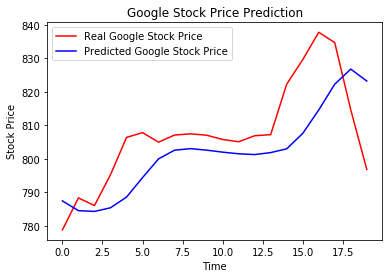

In [26]:
plt.plot(real_stock_price, color = 'red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label='Predicted Google Stock Price')
plt.title("Google Stock Price Prediction")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

You'll notice that during the last days, the model didn't work so well. This is because the RNN hasn't picked up the sudden stock price change. This is normal, because according to FInancial engineering, the future variation are independent from the previous stock prices. But our model so far react to smooth changes.

For our specific Stock Price Prediction problem, evaluating the model with the RMSE does not make much sense, since we are more interested in the directions taken by our predictions, rather than the closeness of their values to the real stock price. We want to check if our predictions follow the same directions as the real stock price and we don’t really care whether our predictions are close the real stock price. The predictions could indeed be close but often taking the opposite direction from the real stock price.